In [2]:
# Load our modularized package
using NavalLBM

println("Environment activated. NavalLBM loaded successfully.")

[ Info: Precompiling NavalLBM [879450b1-5c2d-496c-a765-b8fecb7af3e5] (cache misses: include_dependency fsize change (4))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


Environment activated. NavalLBM loaded successfully.


In [3]:
# 2. Physical and Derived Parameters

# --- Physical Domain (Von Karman Vortex Street) ---
const NX = 300                  # Domain Length
const NY = 100                  # Domain Height
const RE = 100.0                # Reynolds Number
const U_IN = 0.05               # Inlet Velocity (Lattice Units)

# --- Geometry ---
const R_CYL = NY ÷ 9            # Cylinder Radius (~11 nodes)
const CX = NX ÷ 5               # Cylinder Center X
const CY = NY ÷ 2 + 1           # Cylinder Center Y

# --- LBM Parameters ---
const D_CHAR = 2 * R_CYL        # Characteristic Length (Diameter)
const NU = (U_IN * D_CHAR) / RE # Kinematic Viscosity
const TAU = 3.0 * NU + 0.5      # Relaxation Time

# Stability Check
if TAU <= 0.5
    error("Simulation unstable! Tau <= 0.5. Decrease U_in or increase Resolution.")
end

println("--- Parameters ---")
println("Grid:    $NX x $NY")
println("Re:      $RE")
println("U_inlet: $U_IN")
println("D_char:  $D_CHAR")
println("Tau:     $(round(TAU, digits=4))")

--- Parameters ---
Grid:    300 x 100
Re:      100.0
U_inlet: 0.05
D_char:  22
Tau:     0.533


In [4]:
# 3. Simulation Controls

# Total simulation time steps
# (Needs to be long enough for Strouhal analysis)
const MAX_STEPS = 30000 

# Visualization frequency
# (Save a snapshot every 300 steps for the GIF)
const SNAPSHOT_EVERY = 150 

const MEASURE_EVERY = 10

println("Controls set. Simulation will run for $MAX_STEPS steps.")

Controls set. Simulation will run for 30000 steps.


In [5]:
# 4. Setup: State, Geometry, and Probes

println("Initializing Simulation State...")

# A. Initialize Memory
state = initialize_state(NX, NY, TAU)

# B. Create Geometry (Cylinder)
create_cylinder_mask!(state, CX, CY, R_CYL)

# C. Create Channel Walls (Top/Bottom)
state.mask[:, 1] .= true
state.mask[:, end] .= true

# D. Setup Data Containers
# 1. History vector for Strouhal (Time Series)
v_history = Float64[]
sizehint!(v_history, MAX_STEPS)

# 2. Snapshots vector for GIF (Visuals)
# (Using the struct exported from src/core/types.jl)
snapshots = VorticitySnapshot[]

force_history = ForceData{Float64}[]

# E. Define Probe Location (2 Diameters downstream)
const PROBE_PT = (CX + 2*R_CYL + 5, CY)

println("Setup complete. Probe placed at $PROBE_PT.")

Initializing Simulation State...
Setup complete. Probe placed at (87, 51).


In [6]:
# 5. Run Simulation

println("Starting Simulation (Solver)...")

force_history = ForceData{Float64}[]

# We call the solver located in `src/core/solver.jl`
# It should handle the loop, BCs, and data collection.
results = @time run_simulation!(
    state, 
    U_IN, 
    MAX_STEPS,
    snapshot_every=SNAPSHOT_EVERY,
    snapshots=snapshots,
    probe_location=PROBE_PT,
    history_vector=v_history,
    measure_every = MEASURE_EVERY,
    force_history = force_history,
    D_char = Float64(D_CHAR) # Important: Pass the cylinder diameter
)

println("Simulation finished.")
println("Collected $(length(v_history)) data points.")
println("Collected $(length(snapshots)) frames for GIF.")

Starting Simulation (Solver)...


Computing CFD Solution... 100%|██████████████████████████| Time: 0:13:02


Simulation completed successfully.
784.033288 seconds (5.09 M allocations: 362.197 MiB, 0.06% gc time, 0.28% compilation time: 1% of which was recompilation)
Simulation finished.
Collected 30000 data points.
Collected 200 frames for GIF.


In [7]:
# 6. Generate Vorticity GIF

# This tests `src/utils/visualization.jl`
println("Generating GIF...")

gif_name = "refactor_test_vorticity.gif"
generate_vorticity_gif(snapshots, gif_name)

# Display (Markdown trick for Jupyter)
# Returns the file path for display
println("Saved to $gif_name")

Generating GIF...
Generating GIF from 200 frames...
GIF successfully saved to: refactor_test_vorticity.gif
Saved to refactor_test_vorticity.gif


Generating Vector Streamplot...
Generating Streamplot: refactor_test_streamplot.png ...
Image saved successfully.


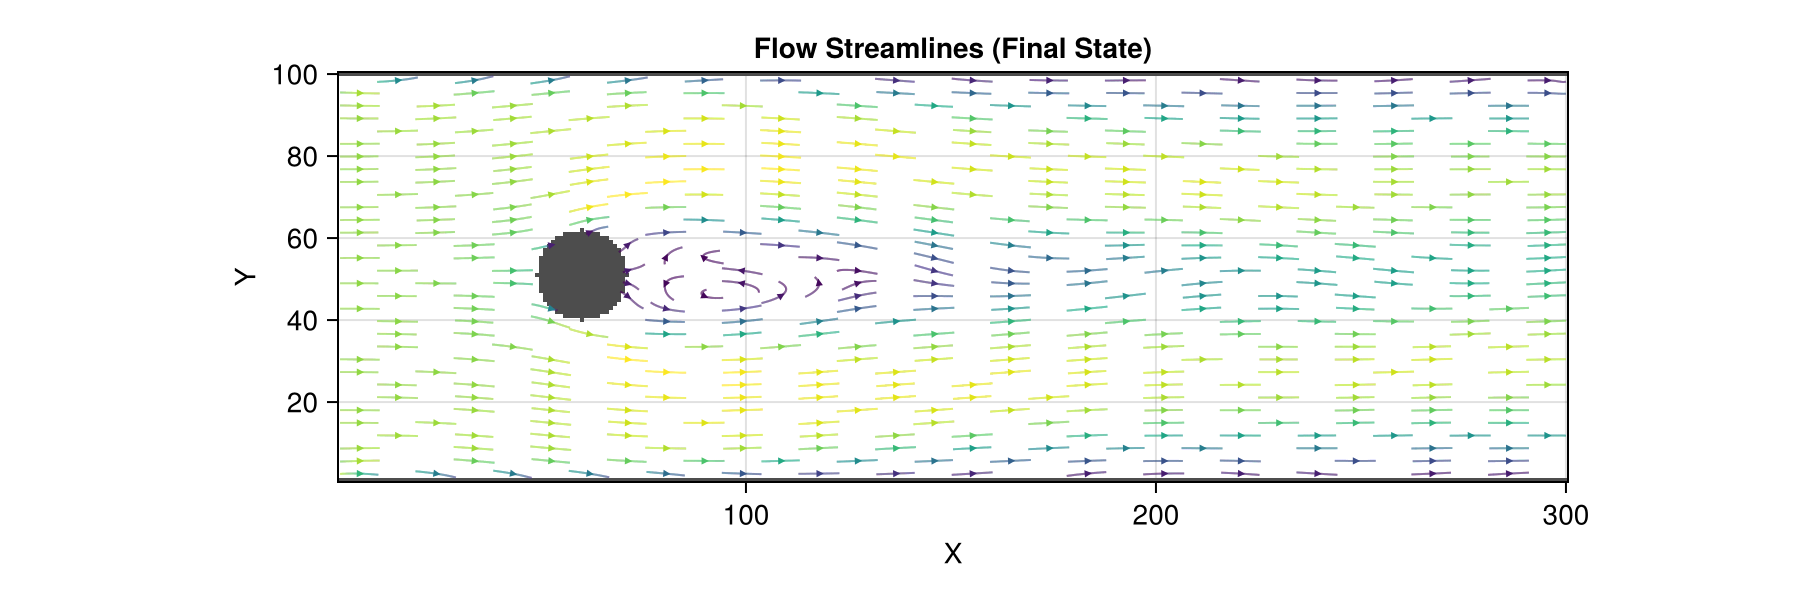

In [8]:
# 7. Generate High-Quality Streamplot

# This tests the generic `save_streamplot` function in `src/utils/visualization.jl`
println("Generating Vector Streamplot...")

# We use the final state of the simulation
img_name = "refactor_test_streamplot.png"
fig = save_streamplot(state, img_name; density=1.2, arrow_size=5)

# Display the figure object inline
fig

Generating Forces plot...
Generating Force History Plot: von_karman_forces.png ...
Plot saved successfully.


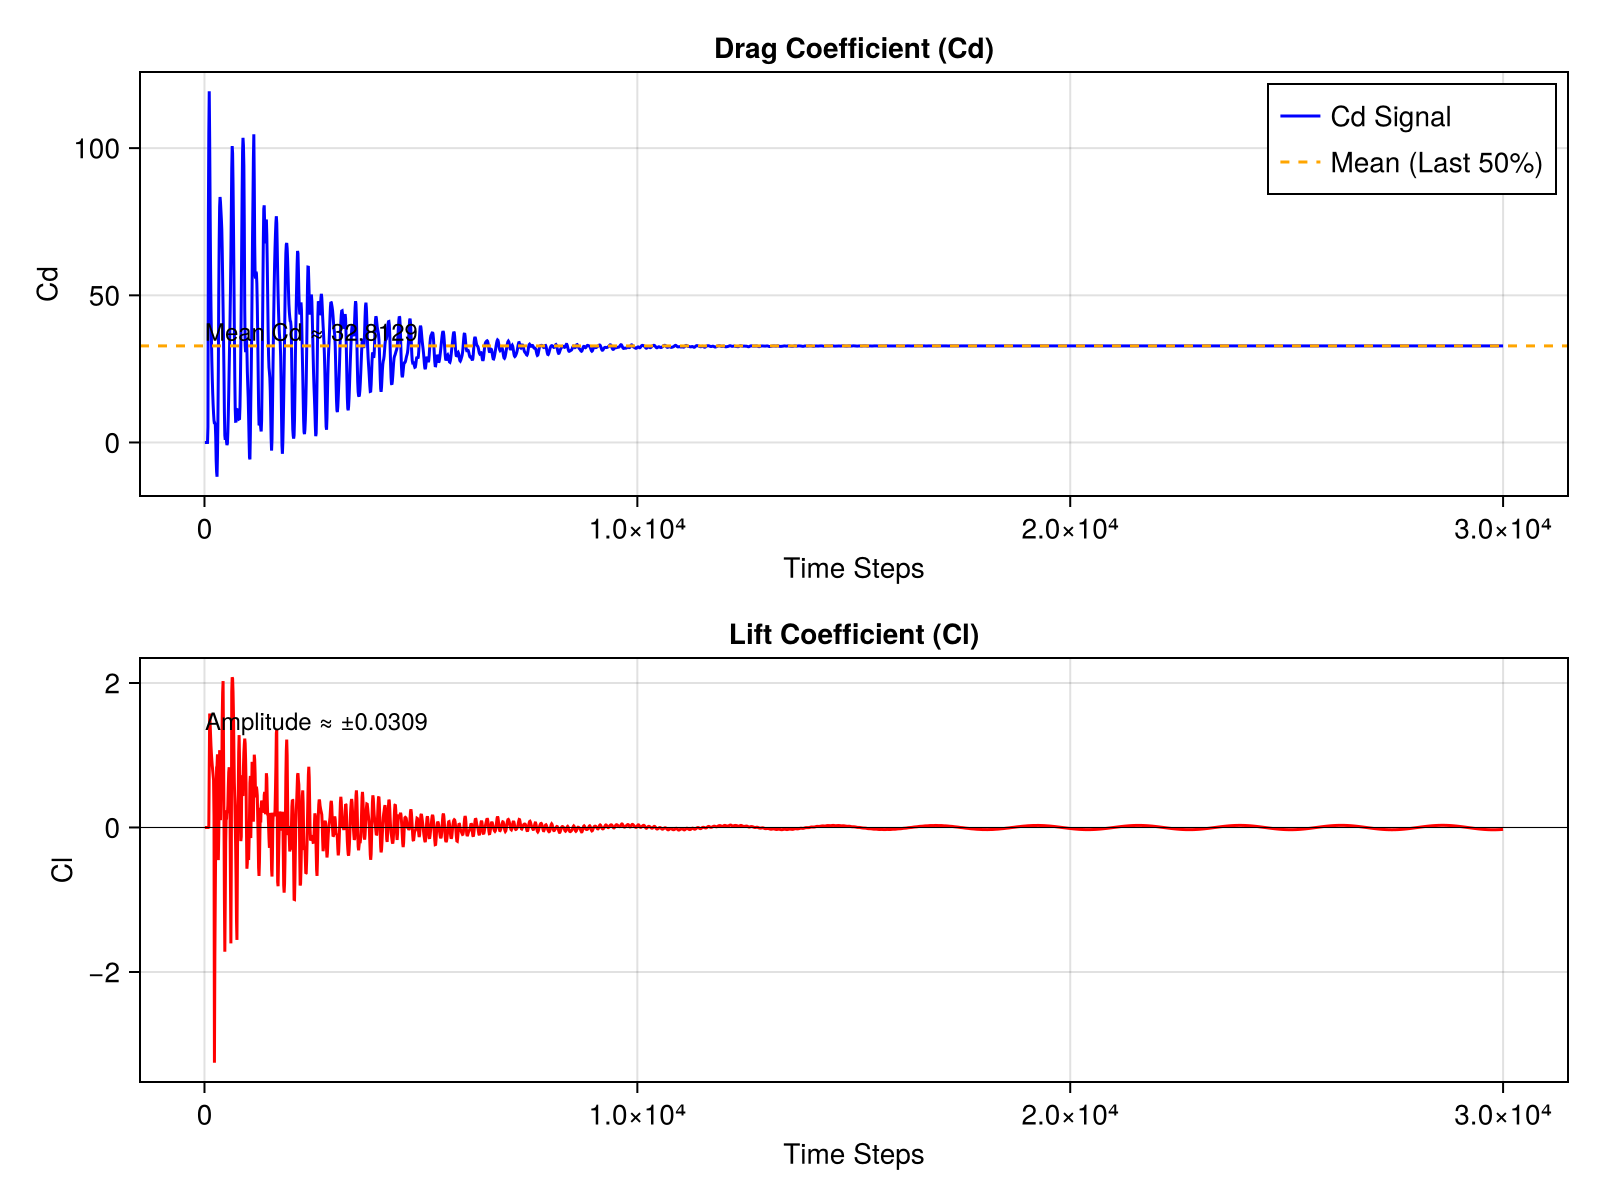

In [9]:
# 8. Force Analysis

println("Generating Forces plot...")

# Plota o histórico e salva em arquivo
fig_forces = plot_force_history(
    force_history,   # O vetor que retornou do run_simulation!
    MEASURE_EVERY,              # measure_every (você usou 10 no exemplo anterior)
    "von_karman_forces.png"
)

# Exibe no notebook
fig_forces

In [10]:
# 9. Performance Benchmark (MLUPS)
using BenchmarkTools
println("Benchmarking Kernel Performance...")

# Create a fresh, clean state for benchmarking
bench_state = initialize_state(NX, NY, TAU)
create_cylinder_mask!(bench_state, CX, CY, R_CYL)

# Define a single-step wrapper (to isolate kernel speed from I/O overhead)
function benchmark_step!(s, u, rho)
    streaming!(s)
    apply_bounce_back!(s)
    apply_zou_he_inlet!(s, u)
    apply_zou_he_outlet!(s, rho)
    calculate_macros!(s)
    collision_bgk!(s)
end

# Run Benchmark
b = @benchmark benchmark_step!($bench_state, $U_IN, 1.0)

# Calculate MLUPS
min_time_sec = minimum(b.times) / 1e9
n_nodes = NX * NY
mlups = (n_nodes / 1e6) / min_time_sec

println("\n--- Benchmark Results ---")
println("Grid: $(NX*NY) nodes")
println("Min Time: $(round(min_time_sec*1000, digits=3)) ms")
println("Performance: $(round(mlups, digits=2)) MLUPS")

Benchmarking Kernel Performance...

--- Benchmark Results ---
Grid: 30000 nodes
Min Time: 18.526 ms
Performance: 1.62 MLUPS


In [11]:
# 10. Strouhal Number Analysis (Physics Validation)
using Test
using FFTW
println("--- Strouhal Analysis (Windowed FFT) ---")

# A. Prepare Signal (Last N points, Hanning Window)
SAMPLE_SIZE = 16384
if length(v_history) >= SAMPLE_SIZE
    signal_raw = v_history[end-SAMPLE_SIZE+1:end]
    
    # Remove Mean
    signal_centered = signal_raw .- mean(signal_raw)
    
    # Hanning Window
    win = 0.5 .* (1.0 .- cos.(2π .* (0:SAMPLE_SIZE-1) ./ (SAMPLE_SIZE-1)))
    signal_final = signal_centered .* win
    
    # B. FFT
    freqs = fftfreq(SAMPLE_SIZE, 1.0)
    S_mag = abs.(fft(signal_final))
    
    # C. Find Peak (Positive spectrum)
    half_n = SAMPLE_SIZE ÷ 2
    val, idx = findmax(S_mag[1:half_n])
    f_lbm = freqs[idx]
    
    # D. Calculate Strouhal
    St = f_lbm * D_CHAR / U_IN
    
    println("Dominant Freq: $(round(f_lbm, digits=5))")
    println("Strouhal (St): $(round(St, digits=4))")
    println("Target Range:  0.170 - 0.190")
    
    @test 0.170 <= St <= 0.195
    println("✅ Physics Validation Passed!")
else
    println("⚠️ Not enough data points for windowed analysis ($SAMPLE_SIZE required).")
end

--- Strouhal Analysis (Windowed FFT) ---
Dominant Freq: 0.00043
Strouhal (St): 0.188
Target Range:  0.170 - 0.190
✅ Physics Validation Passed!
